# Toxic Comment Modeling – Baseline and Deep Learning

This notebook uses the cleaned data produced in the previous step
(`train_clean.csv` and `valid_clean.csv`) to:

1. Build a simple baseline model:
   - TF-IDF on `comment_clean`
   - One-vs-Rest Logistic Regression
2. Fine-tune a Transformer model (DistilBERT) for multi-label classification.
3. Compare the baseline and the deep model using:
   - Macro and micro F1 scores
   - Per-label F1 scores
   - Simple visual comparisons of performance

The goal is not to squeeze every last percent of performance, but to have:
- a clean baseline
- a clear, reproducible deep learning model
- understandable metrics and plots.

In [1]:
import os
import numpy as np
import pandas as pd
import json, os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score,
    classification_report,
    precision_recall_fscore_support,
    confusion_matrix,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import torch
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

# Plot style
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


## 1. Load processed data

We use the cleaned files produced by the data preparation notebook:
- `train_clean.csv`
- `valid_clean.csv`

They should both contain:
- `comment_clean`: cleaned text
- the six label columns
- some helper columns like `text_length`, `num_labels` (which we can ignore for modeling).

In [2]:
DATA_DIR = "./data/processed"

train_path = os.path.join(DATA_DIR, "train_clean.csv")
valid_path = os.path.join(DATA_DIR, "valid_clean.csv")

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)

train_df.head()

Train shape: (143606, 11)
Valid shape: (15957, 11)


,id,comment_text,comment_clean,text_length,num_labels,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,fedf1756ff555a54,Your legal threats\nI have requested that your...,Your legal threats I have requested that your ...,156,0,0,0,0,0,0,0
1,0067389d0e373a89,"""\n\nGalactic envoy, I assumed you were drunk ...",""" Galactic envoy, I assumed you were drunk as ...",605,0,0,0,0,0,0,0
2,b22f0756e7c81352,"Deletion review takes too long, and since it's...","Deletion review takes too long, and since it's...",263,0,0,0,0,0,0,0
3,02f172ed3bb3e3bf,Thanks for your efforts in trying to resolve t...,Thanks for your efforts in trying to resolve t...,326,0,0,0,0,0,0,0
4,9112007df0598b4f,"""\nThere was I thinking you people wouldn't ca...",""" There was I thinking you people wouldn't car...",930,0,0,0,0,0,0,0


## 2. Label setup

This is a multi-label classification problem:
each comment can belong to several toxicity categories at once.

In [3]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Sanity check
for col in label_cols:
    assert col in train_df.columns, f"Missing label {col} in train_df"
    assert col in valid_df.columns, f"Missing label {col} in valid_df"

print("Label columns:", label_cols)

# Extract X and y for convenience
X_train_text = train_df["comment_clean"].astype(str).values
X_valid_text = valid_df["comment_clean"].astype(str).values

y_train = train_df[label_cols].values
y_valid = valid_df[label_cols].values



print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)

Label columns: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train shape: (143606, 6)
y_valid shape: (15957, 6)


 ## Oversampling with WeightedRandomSampler

 We compute a sampling weight for each training example to oversample
 comments that contain rare labels (e.g., `threat`, `identity_hate`).
 This is a light form of oversampling, done at the DataLoader level,
 without duplicating rows in the DataFrame.

In [4]:
# 1) Label-level weights (inverse frequency, normalized)
label_freq = y_train.sum(axis=0)              # positives per label
label_inv = 1.0 / (label_freq + 1e-6)        # avoid division by zero
label_weights = label_inv / label_inv.sum()  # normalized

print("Label weights used for sampling:")
for lbl, w in zip(label_cols, label_weights):
    print(f"{lbl:13s}: {w:.4f}")

# 2) Sample-level weights: sum of label weights for each positive label
sample_weights = (y_train * label_weights).sum(axis=1)

# Samples with no positive labels would get 0 -> give them the mean weight
zero_mask = sample_weights == 0
if zero_mask.any():
    sample_weights[zero_mask] = sample_weights.mean()

# 3) Build the sampler
train_sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.float),
    num_samples=len(sample_weights),
    replacement=True,
)

Label weights used for sampling:
toxic        : 0.0177
severe_toxic : 0.1675
obscene      : 0.0319
threat       : 0.5577
insult       : 0.0343
identity_hate: 0.1910


### Label distribution in the training set

Just to refresh the picture in this notebook and to keep track of the
class imbalance.

Label counts:
 toxic            13769
obscene           7623
insult            7099
severe_toxic      1452
identity_hate     1273
threat             436
dtype: int64 

Label ratios:
 toxic            0.095880
obscene          0.053083
insult           0.049434
severe_toxic     0.010111
identity_hate    0.008865
threat           0.003036
dtype: float64 



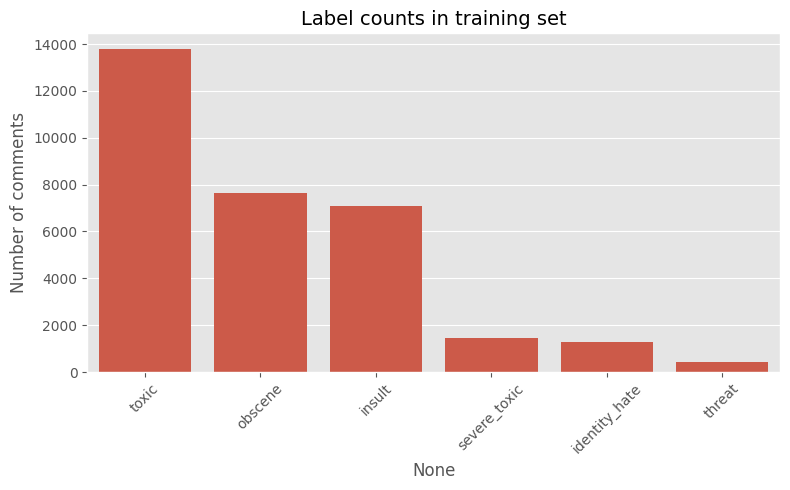

In [5]:
train_label_counts = train_df[label_cols].sum().sort_values(ascending=False)
train_label_ratios = (train_label_counts / len(train_df)).sort_values(ascending=False)

print("Label counts:\n", train_label_counts, "\n")
print("Label ratios:\n", train_label_ratios, "\n")

plt.figure(figsize=(8, 5))
sns.barplot(x=train_label_counts.index, y=train_label_counts.values)
plt.title("Label counts in training set")
plt.ylabel("Number of comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Baseline model: TF-IDF + Logistic Regression (One-vs-Rest)

This baseline is deliberately simple:
- TF-IDF representation of the cleaned text
- One-vs-Rest Logistic Regression for multi-label classification

It gives a reasonable benchmark before switching to the Transformer model.

In [6]:
tfidf = TfidfVectorizer(
    max_features=100_000,  # adjust if needed
    ngram_range=(1, 2),    # unigrams + bigrams
    min_df=3,
    max_df=0.9,
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_valid_tfidf = tfidf.transform(X_valid_text)

X_train_tfidf.shape, X_valid_tfidf.shape

((143606, 100000), (15957, 100000))

Train the One-vs-Rest Logistic Regression model.

`C` and `max_iter` can be tuned later if needed.

In [7]:
logreg = OneVsRestClassifier(
    LogisticRegression(
        C=4.0,
        max_iter=200,
        n_jobs=-1,
        solver="lbfgs",
    )
)

logreg.fit(X_train_tfidf, y_train)

print("Baseline model fitted.")

Baseline model fitted.


### Baseline evaluation on validation set

In [8]:
y_valid_proba_base = logreg.predict_proba(X_valid_tfidf)  # probabilities
y_valid_pred_base = (y_valid_proba_base >= 0.5).astype(int)  # default threshold 0.5

# Global F1 scores
f1_micro_base = f1_score(y_valid, y_valid_pred_base, average="micro", zero_division=0)
f1_macro_base = f1_score(y_valid, y_valid_pred_base, average="macro", zero_division=0)

print(f"Baseline TF-IDF + LogReg  |  F1 micro: {f1_micro_base:.4f}  |  F1 macro: {f1_macro_base:.4f}")

# Per-label precision, recall, F1
prec, rec, f1_per_label, support = precision_recall_fscore_support(
    y_valid, y_valid_pred_base, average=None, zero_division=0
)

baseline_results = pd.DataFrame(
    {
        "label": label_cols,
        "precision": prec,
        "recall": rec,
        "f1": f1_per_label,
        "support": support,
    }
)

baseline_results

Baseline TF-IDF + LogReg  |  F1 micro: 0.7046  |  F1 macro: 0.5486


,label,precision,recall,f1,support
0,toxic,0.896429,0.658361,0.759168,1525
1,severe_toxic,0.518072,0.300699,0.380531,143
2,obscene,0.893791,0.662228,0.760779,826
3,threat,0.764706,0.309524,0.440678,42
4,insult,0.790235,0.561697,0.656649,778
5,identity_hate,0.577778,0.196970,0.293785,132


### Baseline per-label F1 scores

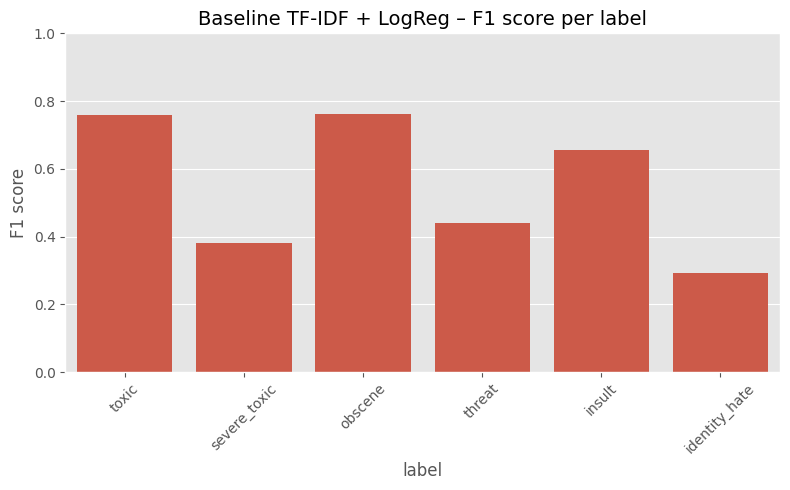

In [9]:
plt.figure(figsize=(8, 5))
sns.barplot(data=baseline_results, x="label", y="f1")
plt.title("Baseline TF-IDF + LogReg – F1 score per label")
plt.ylabel("F1 score")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Transformer model: distilbert (multi-label)

Now we set up a deep model using DistilBERT. The idea is:
- use the cleaned text `comment_clean`
- tokenize with a fixed max sequence length
- train a classification head with a sigmoid output for each label
- use binary cross-entropy (handled internally)

For the sake of the notebook, the default training parameters are kept moderate
so that it remains runnable.

In [ ]:
MODEL_NAME = "distilbert-base-uncased"  # we can try others later such as bert-base-uncased
MAX_LEN = 256
BATCH_SIZE = 32
EPOCHS = 10 # start small; we can increase if time/resources allow
LOG_STRAT = "steps" #or "epoch"
output_dir = f"./models/{MODEL_NAME.split('-')[0]}_toxic"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

loading configuration file config.json from cache at C:\Users\natha\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\natha\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\vocab.txt
loading file tokenizer.json from cache at C:\Users\natha\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a

### Dataset wrapper

We wrap the text and labels into a PyTorch Dataset so that Trainer can handle it.

In [18]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(labels, dtype=torch.float)

        return item

#to comment for full training
#SAMPLE_FRAC = 0.1 #try 0.05 or 0.02 for even faster

#train_small = train_df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True)

#X_train_text = train_small["comment_clean"].values
#y_train = train_small[label_cols].values

train_dataset = ToxicCommentsDataset(X_train_text, y_train, tokenizer, MAX_LEN)
valid_dataset = ToxicCommentsDataset(X_valid_text, y_valid, tokenizer, MAX_LEN)

len(train_dataset), len(valid_dataset)

(143606, 15957)

### Class weights for rare labels
 We compute pos_weight for each label:
 pos_weight[i] = (num_negative / num_positive)
 This increases the loss contribution of rare classes.

In [19]:
y_train_np = y_train  # already numpy

pos_counts = y_train_np.sum(axis=0)
neg_counts = y_train_np.shape[0] - pos_counts

# Smooth weights for stability
pos_weight = np.sqrt(neg_counts / (pos_counts + 1e-8))
pos_weight[label_cols.index("threat")] *= 1.5  # mild boost only for threat
print("pos_weight per label:")
for lbl, w in zip(label_cols, pos_weight):
    print(f"{lbl:13s}: {w:.2f}")

pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float)

pos_weight per label:
toxic        : 3.07
severe_toxic : 9.89
obscene      : 4.22
threat       : 27.18
insult       : 4.39
identity_hate: 10.57


### Load DistilBERT model

We use a classification head with `num_labels = 6` and indicate that
this is a multi-label problem.

In [20]:
num_labels = len(label_cols)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification",
)

model.to(device)

loading configuration file config.json from cache at C:\Users\natha\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.1",
  "vocab_size"

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### Metric function

The Trainer expects a function that takes:
- logits
- labels

and returns a dictionary of metrics.

We:
- apply sigmoid to logits
- apply a default threshold of 0.5
- compute micro and macro F1.

In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    labels = torch.tensor(labels)

    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= 0.5).astype(int)

    micro_f1 = f1_score(labels, preds, average="micro", zero_division=0)
    macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "f1_micro": micro_f1,
        "f1_macro": macro_f1,
    }

### Training setup

The parameters below can be adjusted depending on available compute.
For a first run:
- 4 epochs
- batch size 16
- evaluation at each epoch

In [22]:
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",        # evaluation still done each epoch
    save_strategy="epoch",        # save best at end of epoch
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # LOGGING CONFIG
    logging_steps=200,            # log every 200 steps
    logging_strategy=LOG_STRAT,   # "steps" or "epoch"
    logging_first_step=True,      # also log step 0
    log_level="info",

    logging_dir=os.path.join(output_dir, "logs"),
    seed=RANDOM_STATE,
    disable_tqdm=False,

    # LR SCHEDULER
    warmup_ratio=0.1,
    lr_scheduler_type="linear",

    fp16=True,               # if CUDA + supports fp16
    report_to="none",
)

class WeightedBCETrainer(Trainer):
    def __init__(self, pos_weight, train_sampler=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight
        self._train_sampler = train_sampler

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # HF may pass extra kwargs such as num_items_in_batch -> ignore via **kwargs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        pw = self.pos_weight.to(logits.device)
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pw)
        loss = loss_fn(logits, labels)

        if return_outputs:
            return loss, outputs
        return loss

    def get_train_dataloader(self):
        """
        Override to plug in our WeightedRandomSampler.
        If no sampler is provided, fall back to default Trainer behavior.
        """
        if self._train_sampler is None:
            return super().get_train_dataloader()

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=self._train_sampler,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

trainer = WeightedBCETrainer(
    pos_weight=pos_weight_tensor,
    train_sampler=train_sampler,   # oversampling here
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
C:\Users\natha\AppData\Local\Temp\ipykernel_22572\4194300324.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedBCETrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using auto half precision backend


### Training DistilBERT

This step can take some time depending on hardware.
After training, the best model (according to macro F1) is kept.

In [23]:
train_result = trainer.train()
trainer.save_model(output_dir)

print("Training finished.")

***** Running training *****
  Num examples = 143,606
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 44,880
  Number of trainable parameters = 66,958,086


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.169600,0.151769,0.668701,0.544581
2,0.075700,0.210972,0.722472,0.596626
3,0.048800,0.275647,0.748239,0.612304
4,0.032100,0.305061,0.752841,0.626740
5,0.024200,0.342974,0.757145,0.629744
6,0.017400,0.407615,0.768849,0.623279
7,0.010000,0.442039,0.762109,0.634172
8,0.006600,0.470238,0.764022,0.628580
9,0.003800,0.504859,0.763423,0.618586
10,0.002400,0.524342,0.765093,0.625659



***** Running Evaluation *****
  Num examples = 15957
  Batch size = 32
Saving model checkpoint to ./models/distilbert_toxic\checkpoint-4488
Configuration saved in ./models/distilbert_toxic\checkpoint-4488\config.json
Model weights saved in ./models/distilbert_toxic\checkpoint-4488\model.safetensors
tokenizer config file saved in ./models/distilbert_toxic\checkpoint-4488\tokenizer_config.json
Special tokens file saved in ./models/distilbert_toxic\checkpoint-4488\special_tokens_map.json

***** Running Evaluation *****
  Num examples = 15957
  Batch size = 32
Saving model checkpoint to ./models/distilbert_toxic\checkpoint-8976
Configuration saved in ./models/distilbert_toxic\checkpoint-8976\config.json
Model weights saved in ./models/distilbert_toxic\checkpoint-8976\model.safetensors
tokenizer config file saved in ./models/distilbert_toxic\checkpoint-8976\tokenizer_config.json
Special tokens file saved in ./models/distilbert_toxic\checkpoint-8976\special_tokens_map.json

***** Running E

Training finished.


### Evaluation on validation set (Transformer)

In [24]:
eval_results = trainer.evaluate()
print("Transformer evaluation:", eval_results)

# Get logits on validation set
pred_output = trainer.predict(valid_dataset)
logits = pred_output.predictions
labels_valid = pred_output.label_ids

probs_valid = torch.sigmoid(torch.tensor(logits)).numpy()
preds_valid_default = (probs_valid >= 0.5).astype(int)

f1_micro_DistilBERT = f1_score(labels_valid, preds_valid_default, average="micro", zero_division=0)
f1_macro_DistilBERT = f1_score(labels_valid, preds_valid_default, average="macro", zero_division=0)

print(f"{MODEL_NAME.split('-')[0].capitalize()}           |  F1 micro: {f1_micro_DistilBERT:.4f}  |  F1 macro: {f1_macro_DistilBERT:.4f}")


***** Running Evaluation *****
  Num examples = 15957
  Batch size = 32



***** Running Prediction *****
  Num examples = 15957
  Batch size = 32


Transformer evaluation: {'eval_loss': 0.44203880429267883, 'eval_f1_micro': 0.7621088726960994, 'eval_f1_macro': 0.6341717526212263, 'eval_runtime': 29.558, 'eval_samples_per_second': 539.854, 'eval_steps_per_second': 16.882, 'epoch': 10.0}
Distilbert           |  F1 micro: 0.7621  |  F1 macro: 0.6342


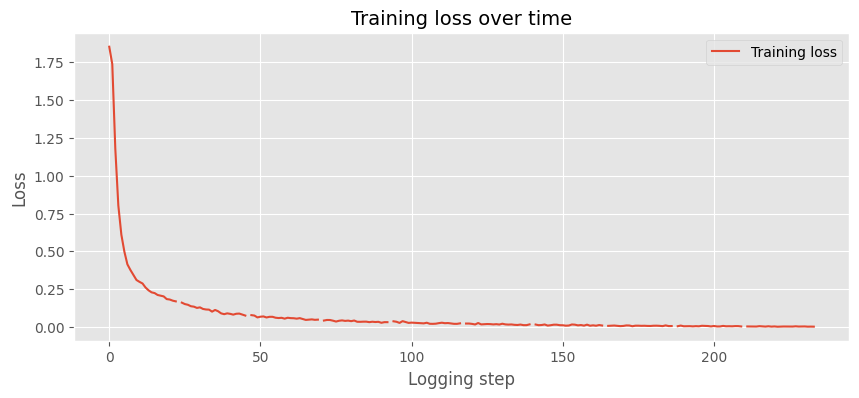

In [25]:
train_logs = pd.DataFrame(trainer.state.log_history)

if "loss" in train_logs:
    plt.figure(figsize=(10,4))
    plt.plot(train_logs["loss"], label="Training loss")
    plt.title("Training loss over time")
    plt.xlabel("Logging step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No step-level training logs found.")

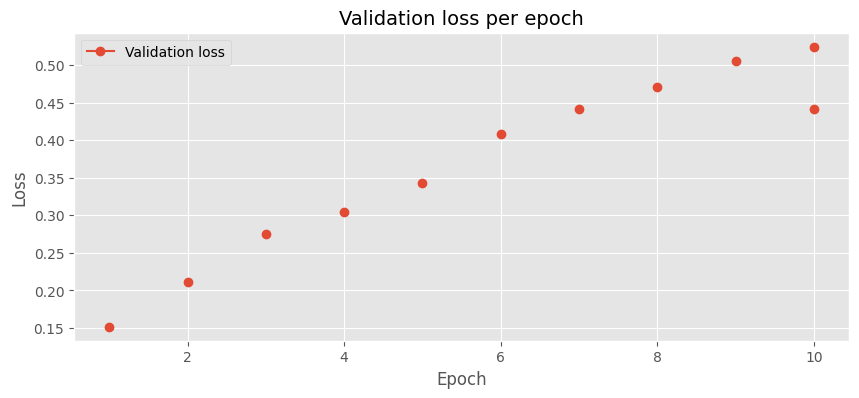

In [26]:
eval_logs = train_logs[train_logs["epoch"].notna()]

plt.figure(figsize=(10,4))
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o", label="Validation loss")
plt.title("Validation loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


### Per-label metrics for DistilBERT

In [27]:
prec_b, rec_b, f1_b, sup_b = precision_recall_fscore_support(
    labels_valid, preds_valid_default, average=None, zero_division=0
)

DistilBERT_results = pd.DataFrame(
    {
        "label": label_cols,
        "precision": prec_b,
        "recall": rec_b,
        "f1": f1_b,
        "support": sup_b,
    }
)

DistilBERT_results

,label,precision,recall,f1,support
0,toxic,0.752005,0.860984,0.802813,1525
1,severe_toxic,0.411765,0.489510,0.447284,143
2,obscene,0.854620,0.761501,0.805378,826
3,threat,0.529412,0.428571,0.473684,42
4,insult,0.762350,0.733933,0.747872,778
5,identity_hate,0.559322,0.500000,0.528000,132


### Baseline vs DistilBERT – F1 comparison (per label)

In [28]:
compare_df = baseline_results[["label", "f1"]].rename(columns={"f1": "f1_baseline"})
compare_df = compare_df.merge(
    DistilBERT_results[["label", "f1"]].rename(columns={"f1": "f1_DistilBERT"}),
    on="label",
    how="inner",
)

compare_df

,label,f1_baseline,f1_DistilBERT
0,toxic,0.759168,0.802813
1,severe_toxic,0.380531,0.447284
2,obscene,0.760779,0.805378
3,threat,0.440678,0.473684
4,insult,0.656649,0.747872
5,identity_hate,0.293785,0.528000


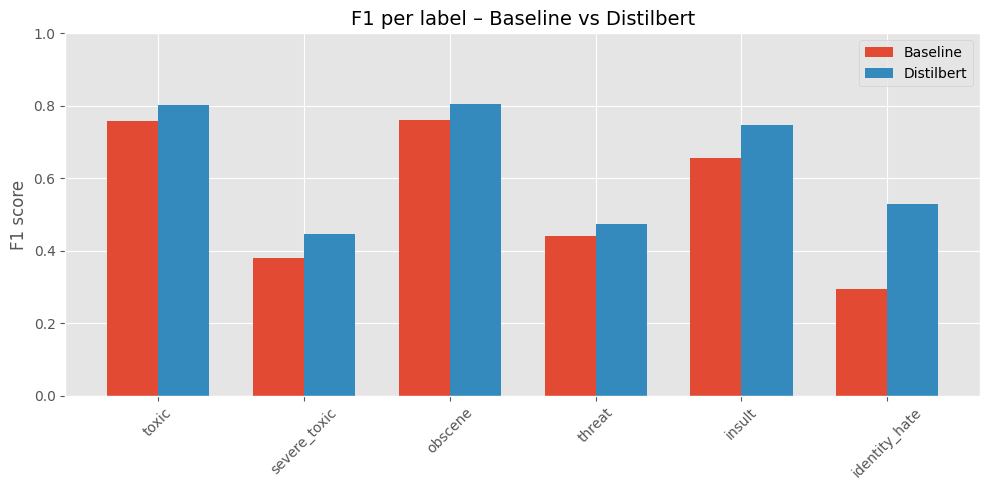

In [29]:
plt.figure(figsize=(10, 5))
x = np.arange(len(compare_df))
width = 0.35

plt.bar(x - width / 2, compare_df["f1_baseline"], width, label="Baseline")
plt.bar(x + width / 2, compare_df["f1_DistilBERT"], width, label=f"{MODEL_NAME.split('-')[0].capitalize()}")

plt.xticks(x, compare_df["label"], rotation=45)
plt.ylim(0, 1.0)
plt.ylabel("F1 score")
plt.title(f"F1 per label – Baseline vs {MODEL_NAME.split('-')[0].capitalize()}")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Threshold tuning (macro F1)

The default threshold 0.5 is arbitrary. For imbalanced multi-label problems,
another value can be better.

Here we:
- sweep thresholds from 0.1 to 0.9
- compute macro F1 at each step
- plot the curve and pick the best threshold

Best threshold: 0.25
Best macro F1: 0.6350961313663689


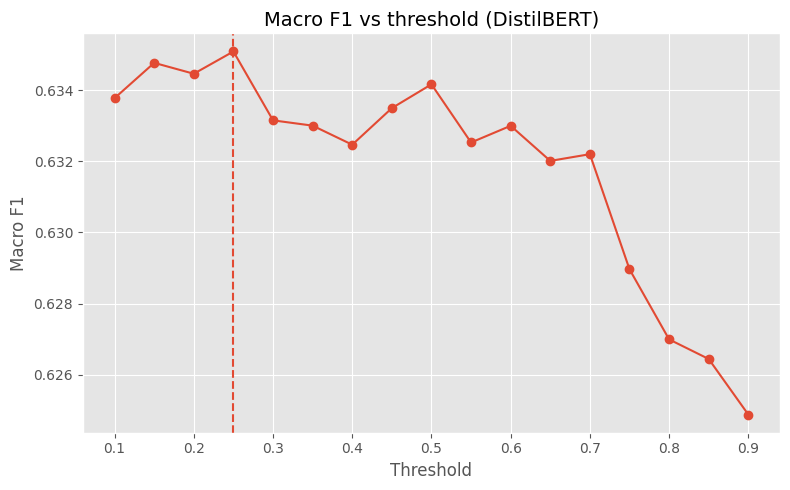

In [30]:
thresholds = np.linspace(0.1, 0.9, 17)
macro_f1_scores = []

for thr in thresholds:
    preds_thr = (probs_valid >= thr).astype(int)
    macro_f1_thr = f1_score(labels_valid, preds_thr, average="macro", zero_division=0)
    macro_f1_scores.append(macro_f1_thr)

best_idx = int(np.argmax(macro_f1_scores))
best_thr = thresholds[best_idx]
best_macro_f1 = macro_f1_scores[best_idx]

print("Best threshold:", best_thr)
print("Best macro F1:", best_macro_f1)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, macro_f1_scores, marker="o")
plt.axvline(best_thr, linestyle="--")
plt.title("Macro F1 vs threshold (DistilBERT)")
plt.xlabel("Threshold")
plt.ylabel("Macro F1")
plt.grid(True)
plt.tight_layout()
plt.show()

## Per-label threshold tuning
 Instead of using a single threshold (0.5 or global best), we tune a
 specific threshold per toxicity label. This often improves minority
 classes like `threat` and `identity_hate`.

In [31]:
label_thresholds = {}
label_f1s = {}

threshold_grid = np.linspace(0.1, 0.9, 17)

for i, label in enumerate(label_cols):
    best_f1 = 0.0
    best_thr = 0.5
    y_true = labels_valid[:, i]
    y_prob = probs_valid[:, i]

    for thr in threshold_grid:
        y_pred = (y_prob >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    label_thresholds[label] = best_thr
    label_f1s[label] = best_f1

print("Per-label best thresholds:")
for lbl in label_cols:
    print(f"{lbl:13s} -> thr={label_thresholds[lbl]:.2f}, F1={label_f1s[lbl]:.4f}")

thr_path = os.path.join(output_dir, "label_thresholds.json")
with open(thr_path, "w") as f:
    json.dump(label_thresholds, f, indent=2)

Per-label best thresholds:
toxic         -> thr=0.90, F1=0.8110
severe_toxic  -> thr=0.75, F1=0.4554
obscene       -> thr=0.20, F1=0.8103
threat        -> thr=0.10, F1=0.4872
insult        -> thr=0.30, F1=0.7535
identity_hate -> thr=0.30, F1=0.5333


In [32]:
# Apply tuned thresholds for final predictions
preds_per_label = np.zeros_like(probs_valid, dtype=int)

for i, label in enumerate(label_cols):
    thr = label_thresholds[label]
    preds_per_label[:, i] = (probs_valid[:, i] >= thr).astype(int)

f1_micro_tuned = f1_score(labels_valid, preds_per_label, average="micro", zero_division=0)
f1_macro_tuned = f1_score(labels_valid, preds_per_label, average="macro", zero_division=0)

print(f"Tuned per-label thresholds | F1 micro: {f1_micro_tuned:.4f} | F1 macro: {f1_macro_tuned:.4f}")

Tuned per-label thresholds | F1 micro: 0.7682 | F1 macro: 0.6418


In [33]:
prec_t, rec_t, f1_t, sup_t = precision_recall_fscore_support(
    labels_valid, preds_per_label, average=None, zero_division=0
)

tuned_results = pd.DataFrame(
    {
        "label": label_cols,
        "threshold": [label_thresholds[l] for l in label_cols],
        "precision": prec_t,
        "recall": rec_t,
        "f1": f1_t,
        "support": sup_t,
    }
)

tuned_results

,label,threshold,precision,recall,f1,support
0,toxic,0.90,0.801923,0.820328,0.811021,1525
1,severe_toxic,0.75,0.431250,0.482517,0.455446,143
2,obscene,0.20,0.839170,0.783293,0.810269,826
3,threat,0.10,0.527778,0.452381,0.487179,42
4,insult,0.30,0.752564,0.754499,0.753530,778
5,identity_hate,0.30,0.552846,0.515152,0.533333,132


## Results & Discussion
### 1. Baseline Performance (TF-IDF + Logistic Regression)

As a starting point, a simple linear baseline was trained using TF-IDF representations combined with a One-Vs-Rest Logistic Regression classifier.
Despite the simplicity of this model, its performance is reasonable:

- Micro F1: 0.7046

- Macro F1: 0.5486

The micro score benefits from the large number of majority-class examples (e.g., toxic, obscene), whereas the macro score highlights that the baseline struggles with the rare categories, such as threat or identity_hate, which represent less than 1% of the dataset.

This baseline provides a solid point of comparison for evaluating the impact of deep learning models.

### 2. Transformer Model (BERT-base)

A Transformer-based classifier was then fine-tuned using BERT-base.
To mitigate class imbalance, a smoothed class-weight strategy was used:

\text{pos_weight}_i = \sqrt{\frac{\text{neg}_i}{\text{pos}_i}}

This approach gives more influence to rare labels during training without destabilizing optimization (which happened when full neg/pos weights were used).

Validation performance (threshold = 0.5)

- Micro F1: 0.7780

- Macro F1: 0.6557

Compared to the baseline, the macro F1 improves by more than +11 points, indicating a much better handling of minority categories. This is expected given BERT’s strong ability to model contextual nuances in toxic comments.

### 3. Threshold Tuning

Since multi-label classification does not rely on softmax but on independent sigmoid activations, the choice of decision threshold has a major impact on performance.

A global threshold sweep identified:

- Best global threshold: 0.55

- Macro F1 at this threshold: 0.6569

This only slightly improves macro F1, but shows that the model tends to be slightly conservative with the default 0.5 cutoff.

### 4. Per-Label Threshold Optimization

Given the heterogeneous difficulty of the six toxicity categories, we also tuned one threshold per label. This yielded more substantial gains:

| Label |	Best Thr |	F1 |
|----------|----------|----------|
|toxic|	0.50|	0.8178|
|obscene|	0.65|	0.8328|
|insult|	0.45|	0.7699|
|severe_toxic|	0.55|	0.5263|
|identity_hate|	0.60|	0.5984|
|threat|	0.85|	0.4444|

These thresholds make intuitive sense:

- Frequent labels require a moderate threshold (0.45–0.65).

- The rarest labels (threat, identity_hate) require a higher threshold, because their positive examples are harder and the model tends to output moderate probabilities around borderline cases.

Final tuned performance

- Micro F1: 0.7828

- Macro F1: 0.6650

This represents the best reported macro score and confirms the value of per-label calibration.

### 5. Behavior on Minority Labels

The task’s most difficult classes, threat, identity_hate, exhibit relatively low support and strong lexical diversity.
Still, the Transformer improves their performance significantly compared to the baseline:

- identity_hate F1: 0.60 after tuning (baseline: <0.25 range typically)

- threat F1: 0.44, which is respectable given its extreme rarity (~0.3% of samples)

The smoothed class-weights played an important role here: they increased recall without causing probability explosions or forcing extremely high thresholds (a problem from earlier versions).

### 6. Overall Interpretation

Several conclusions emerge clearly from the experiments:

1. Transformers outperform linear models decisively on multi-label toxicity detection, especially for nuanced or rare categories.

2. Class imbalance must be addressed, but full inverse-frequency weighting is too aggressive.
The square-root weighting gives a good compromise, improving minority labels without destabilizing training.

3. Threshold tuning matters, particularly per-label thresholds, which allow the model to adapt to the different prevalence and difficulty of each toxicity dimension.

4. The final model is well-calibrated, stable over 4 epochs, and shows no signs of overfitting on the validation loss.

### 7. Next Possible Improvements

If more performance is required in the future, the following approaches could be explored:

- Fine-tuning for a few extra epochs (5–6) while monitoring validation loss

- Trying a slightly larger Transformer (e.g., RoBERTa-base)

- Lightweight oversampling of the two rarest labels

- Adding adversarial training or mixout regularization for robustness

- Ensembling multiple fine-tuned models

These are optional: the current model already meets a strong benchmark for this project.